In [79]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [80]:
data = pd.read_csv(r'C:\Users\dvale\TFM\Data\all_variables.csv')

In [81]:
data = data[data.age > 18].reset_index(drop=True)

In [82]:
print(data.shape)
print(data.columns)

(32514, 26)
Index(['Unnamed: 0', 'id', 'weight', 'material_deprivation', 'sex', 'age',
       'civil_status', 'familial_status', 'region', 'population_density',
       'citizenship', 'tenure_status', 'education_level', 'working_status',
       'working_status_agg', 'occupation', 'economic_sector', 'years_worked',
       'hours_week_worked', 'income', 'person_room',
       'self_perceived_bad_health', 'has_health_limitations',
       'has_chronic_condition', 'unmet_medical_treatment', 'has_support_net'],
      dtype='object')


In [83]:
data = data.drop(['Unnamed: 0', 'id', 'weight', 'economic_sector', 'income'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32514 entries, 0 to 32513
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   material_deprivation       32514 non-null  object 
 1   sex                        32514 non-null  object 
 2   age                        32514 non-null  int64  
 3   civil_status               32514 non-null  object 
 4   familial_status            32514 non-null  object 
 5   region                     32514 non-null  object 
 6   population_density         32514 non-null  object 
 7   citizenship                32514 non-null  object 
 8   tenure_status              32514 non-null  object 
 9   education_level            32514 non-null  object 
 10  working_status             32514 non-null  object 
 11  working_status_agg         32514 non-null  object 
 12  occupation                 32514 non-null  object 
 13  years_worked               32514 non-null  int

In [84]:
data.person_room = data.person_room.fillna(data.person_room.median())

In [85]:
data.working_status.unique()

array(['Retired', 'Unpaid carer/domestic worker',
       'Disabled/unfit to work', 'Unemployed', 'Student', 'Employed',
       'Self-employed'], dtype=object)

In [86]:
data.working_status = np.where(data.working_status == 'Self-employed', 'Employed', data.working_status)
data.working_status.unique()

array(['Retired', 'Unpaid carer/domestic worker',
       'Disabled/unfit to work', 'Unemployed', 'Student', 'Employed'],
      dtype=object)

In [87]:
data = data.drop(['working_status_agg'], axis=1)

In [88]:
scaler = StandardScaler()

num_var = data[['age', 'years_worked', 'hours_week_worked', 'person_room']]
scaler.fit(num_var)
scaled_var = pd.DataFrame(scaler.transform(num_var), columns=num_var.columns)

data.age = scaled_var.age
data.hours_week_worked = scaled_var.hours_week_worked
data.years_worked = scaled_var.years_worked
#data.income = scaled_var.income
data.person_room = scaled_var.person_room

data.head()

,material_deprivation,sex,age,civil_status,familial_status,region,population_density,citizenship,tenure_status,education_level,working_status,occupation,years_worked,hours_week_worked,person_room,self_perceived_bad_health,has_health_limitations,has_chronic_condition,unmet_medical_treatment,has_support_net
0,No,Male,0.972748,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Retired,Clerical Support Workers,1.660637,-0.890916,0.430935,Yes,Yes,Yes,No,Yes
1,No,Female,0.861438,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Unpaid carer/domestic worker,Clerical Support Workers,-1.205845,-0.890916,0.430935,No,No,Yes,No,Yes
2,No,Female,1.084058,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Lower secondary education,Unpaid carer/domestic worker,Elementary Occupations,-0.059252,-0.890916,0.430935,No,No,No,No,Yes
3,No,Male,0.416197,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Retired,Services and Sales Workers,0.896242,-0.890916,0.430935,No,No,No,No,Yes
4,No,Female,0.082267,Divorced,Yes,Basque Country,Thinly-populated area,Spain,Outright owner,Higher education,Disabled/unfit to work,Services and Sales Workers,0.577744,-0.890916,-0.322031,No,Yes,Yes,No,Yes


In [89]:
def get_dummies(df):
    new_df = pd.DataFrame()
    for c in df.columns:
        if type(df[c][0]) == type('string'):
            dummy_df = pd.get_dummies(df[c])
            for dummy_column in dummy_df.columns:
                new_df[c + '_' + dummy_column] = dummy_df[dummy_column]
        else:
            new_df[c] = df[c]
    return new_df

In [90]:
data_final = get_dummies(data.drop(['material_deprivation'], axis=1))

data_final.head()

,sex_Female,sex_Male,age,civil_status_Divorced,civil_status_Married,civil_status_Married 'de facto',civil_status_Never married,civil_status_Separated,civil_status_Widowed,familial_status_No,...,self_perceived_bad_health_No,self_perceived_bad_health_Yes,has_health_limitations_No,has_health_limitations_Yes,has_chronic_condition_No,has_chronic_condition_Yes,unmet_medical_treatment_No,unmet_medical_treatment_Yes,has_support_net_No,has_support_net_Yes
0,0,1,0.972748,0,1,0,0,0,0,1,...,0,1,0,1,0,1,1,0,0,1
1,1,0,0.861438,0,1,0,0,0,0,1,...,1,0,1,0,0,1,1,0,0,1
2,1,0,1.084058,0,1,0,0,0,0,1,...,1,0,1,0,1,0,1,0,0,1
3,0,1,0.416197,0,1,0,0,0,0,1,...,1,0,1,0,1,0,1,0,0,1
4,1,0,0.082267,1,0,0,0,0,0,0,...,1,0,0,1,0,1,1,0,0,1


In [91]:
data_final['material_deprivation'] = data.material_deprivation.map({'Yes': 1, 'No': 0})

count_yes = len(data_final[data_final.material_deprivation == 1])
count_no = len(data_final[data_final.material_deprivation == 0])
freq_yes = (count_yes/(count_yes+count_no))*100
freq_no = (count_no/(count_yes+count_no))*100

print('''Has material deprivation: {}%
Does not have material deprivation: {}%'''.format(round(freq_yes, 2), round(freq_no, 2)))

Has material deprivation: 4.3%
Does not have material deprivation: 95.7%


In [92]:
X = data_final.drop(['material_deprivation'], axis=1)
y = data_final.material_deprivation

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [93]:
decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7794
           1       0.21      0.24      0.22       335

    accuracy                           0.93      8129
   macro avg       0.59      0.60      0.59      8129
weighted avg       0.94      0.93      0.93      8129



In [94]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7501  293]
 [ 256   79]]


In [95]:
proba_material_deprivation = [proba[1] for proba in decision_tree.predict_proba(X_test)]

In [96]:
testing_data = X_test.copy()
testing_data['material_deprivation'] = y_test.copy()
testing_data['proba_material_deprivation'] = proba_material_deprivation

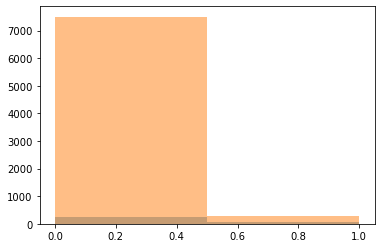

In [97]:
plt.hist(x='proba_material_deprivation', bins=2, data=testing_data[testing_data.material_deprivation == 1].reset_index(), 
         alpha=0.5, density=False)
plt.hist(x='proba_material_deprivation', bins=2, data=testing_data[testing_data.material_deprivation == 0].reset_index(), 
         alpha=0.5, density=False);